Being situated in California on the San Andreas fault we experience a lot of earthquakes throughout the year. For this reason I thought it would be valuable to explore and create a model to predict the likelihood of an earthquake given a limited number of paramters. Throughout the report we will use worldwide data of notorous earthquakes to create a basic neural network that will predict the likelihood of an earthquake given inputs such as date, time, longitude, latitude, and magnitude.

In [1]:
# Importing necessary tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Reading in the dataset
data = pd.read_csv('database.csv')
data.head(10)

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
5,01/10/1965,13:36:32,-13.405,166.629,Earthquake,35.0,NaN,NaN,6.7,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860922,ISCGEM,ISCGEM,ISCGEM,Automatic
6,01/12/1965,13:32:25,27.357,87.867,Earthquake,20.0,NaN,NaN,5.9,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM861007,ISCGEM,ISCGEM,ISCGEM,Automatic
7,01/15/1965,23:17:42,-13.309,166.212,Earthquake,35.0,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM861111,ISCGEM,ISCGEM,ISCGEM,Automatic
8,01/16/1965,11:32:37,-56.452,-27.043,Earthquake,95.0,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEMSUP861125,ISCGEMSUP,ISCGEM,ISCGEM,Automatic
9,01/17/1965,10:43:17,-24.563,178.487,Earthquake,565.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM861148,ISCGEM,ISCGEM,ISCGEM,Automatic


In [3]:
# Dimensions of dataset
data.shape

(23412, 21)

In the table above we can see that we are given the following columns:
- Date 
- Time
- Latitude
- Longitude
- Type of natural disaster
- Depth
- Depth error
- Depth seismic stations
- Magnitude
- Magnitude type
- Magnitude seismic stations
- Azimuthal gap
- Horizontal distance
- Horizontal error
- Root mean square
- ID
- Source
- Location source
- Magnitude source
- Status

The following features will be condensed in order to limit the size of our model. In our dataset we have a total of 23,412 unique data points and 21 features. 

In [4]:
# Condensing our dataset
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.head(10)

,Date,Time,Latitude,Longitude,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,15.0,5.8
5,01/10/1965,13:36:32,-13.405,166.629,35.0,6.7
6,01/12/1965,13:32:25,27.357,87.867,20.0,5.9
7,01/15/1965,23:17:42,-13.309,166.212,35.0,6.0
8,01/16/1965,11:32:37,-56.452,-27.043,95.0,6.0
9,01/17/1965,10:43:17,-24.563,178.487,565.0,5.8


In order to manipulate the data more effectively we are going to convert our data and time features into Unix time. Unix time is just a system to represent a point in time, more specifically it is the number of seconds that have elapsed since January 1, 1970. The main benefit in converting our date and time features is that Unix time can be represented as an integer making it easier to parse through. 

In [5]:
# Importing necessary packages
import datetime
import time

# Initializing an empty list to append the unix conversion values
timestamp = []

# Converting our date and time data from our dataset into a unix time value
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        # print('ValueError')
        timestamp.append('ValueError')
        
# Adding our new timestamp list with the unix values into our dataframe
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head(10)

,Latitude,Longitude,Depth,Magnitude,Timestamp
0,19.246,145.616,131.6,6.0,-157601742.0
1,1.863,127.352,80.0,5.8,-157437011.0
2,-20.579,-173.972,20.0,6.2,-157326842.0
3,-59.076,-23.557,15.0,5.8,-157065017.0
4,11.938,126.427,15.0,5.8,-156997630.0
5,-13.405,166.629,35.0,6.7,-156911008.0
6,27.357,87.867,20.0,5.9,-156738455.0
7,-13.309,166.212,35.0,6.0,-156444138.0
8,-56.452,-27.043,95.0,6.0,-156400043.0
9,-24.563,178.487,565.0,5.8,-156316603.0


# Data Visualization

Now we are going to visualize our data before creating our model. Below I plot a world map with the associated frequencies of the earthquake.

In [6]:
# conda install -c conda-forge basemap
# Installing the necessary tools to produce the map
# Also try !pip install basemap

In [7]:
#conda install -c conda-forge proj4

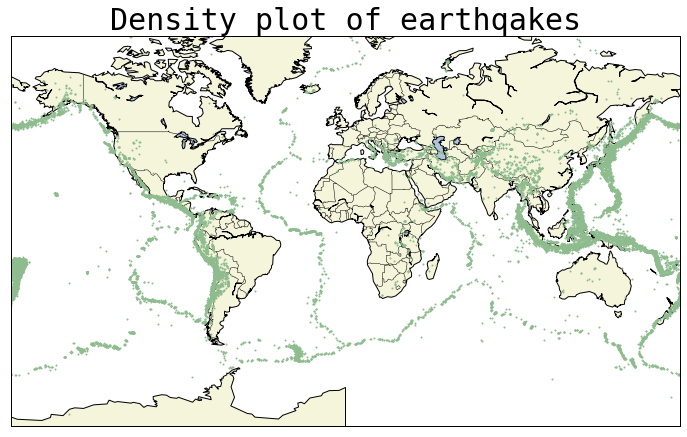

In [8]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
#m = Basemap(width=12000000,height=9000000,projection='lcc',
            #resolution=None,lat_1=80.,lat_2=55,lat_0=80,lon_0=-107.)
x,y = m(longitudes,latitudes)


fig = plt.figure(figsize=(12,10))
plt.title("Density plot of earthqakes", color = 'black', font = 'monospace', fontsize = 30)
m.plot(x, y, "o", markersize = 1, color = 'darkseagreen')
m.drawcoastlines()
m.fillcontinents(color='beige',lake_color='lightsteelblue')
m.drawmapboundary()
m.drawcountries()
plt.show()

# Building the model

Now we will create the prediction model. In order to do so we will have to split the data into feature inputs, x variables, and y, our output variables. In our model, I will use the standard 70/30 in order to split the data into training and testing data. 

In [9]:
# Parsing out our input/output variables
X = final_data[['Timestamp', 'Latitude', 'Longitude']]
y = final_data[['Magnitude', 'Depth']]

In [10]:
# Splitting the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In our model when splitting the training and testing data we use a random state number of 10 because we would like to preserve our model and to be able to repicate the problem everytime we run the Jupyter notebook in the future.

In [11]:
# Reference the shape of our training and testing data for our neural network
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(16386, 3) (7023, 3) (16386, 2) (7023, 3)


# Neural Network: Earthquake Prediction

In [12]:
#pip install scikeras

In [13]:
# pip install tensorflow
from tensorflow import keras

In [14]:
# Importing necessary packages
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
# Building our network using softmax
def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [16]:
model = KerasClassifier(build_fn=create_model, verbose=0, activation='sigmoid', neurons=16)
# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

In [17]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/scikeras/wrappers.py", line 1453, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/Applications/anaconda3/lib/python3.9/site-packages/scikeras/wrappers.py", line 725, in fit
    self._fit(
  File "/Ap

ValueError: Unknown label type: continuous-multioutput.

To implement support, subclass KerasClassifier and override ``target_encoder`` with a transformer that supports this label type.

For information on sklearn target types, see: * https://scikit-learn.org/stable/modules/generated/sklearn.utils.multiclass.type_of_target.html * https://scikit-learn.org/stable/modules/multiclass.html

For information on the SciKeras data transformation interface, see: * https://www.adriangb.com/scikeras/stable/advanced.html#data-transformers

In [18]:
model1 = Sequential()
model1.add(Dense(16, activation='sigmoid', input_shape=(3,)))
model1.add(Dense(16, activation='sigmoid'))
model1.add(Dense(2, activation='softmax'))

model1.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])
model1.fit(X_train.astype('float32'), y_train.astype('float32'), batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

[test_loss, test_acc] = model1.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

2022-03-06 19:47:36.615495: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
1614/1639 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9814

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).